In [41]:
import os
import jams
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
from scipy.io import wavfile
import math

In [71]:
# Load audio and define paths
path = 'D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/'
#path_audio = path + "audio_hex-pickup_debleeded/"
path_audio = path + "audio_mono-mic/"
path_anno = path + "annotation/"

In [5]:
def audio_CQT(file_num, start, dur):  # start and dur in seconds

    # Function for removing noise
    def cqt_lim(CQT):
        new_CQT = np.copy(CQT)
        new_CQT[new_CQT < -60] = -120
        return new_CQT

    # Perform the Constant-Q Transform
    data, sr = librosa.load(os.path.join(path_audio, os.listdir(path_audio)[file_num]), sr = None, mono = True, offset = start, duration = dur)
    #data = librosa.resample(data, sr_original, 22050)
    CQT = librosa.cqt(data, sr = 22050, hop_length = 1024, fmin = None, n_bins = 96, bins_per_octave = 12)
    CQT_mag = librosa.magphase(CQT)[0]**4
    CQTdB = librosa.core.amplitude_to_db(CQT_mag, ref = np.amax)
    new_CQT = cqt_lim(CQTdB)

    return new_CQT

In [59]:
def spacejam(file_num, start, stop):
    
    path = os.path.join(path_anno, os.listdir(path_anno)[file_num])
    jam = jams.load(path)

    # Initialize variables
    cnt_row = -1
    cnt_col = 0
    cnt_zero = 0

    # Grab all relevant MIDI data (available in MIDI_dat)
    for i in range(0, len(jam['annotations'])):
        if jam['annotations'][int(i)]['namespace'] == 'note_midi':
            for j in range(0, len(sorted(jam['annotations'][int(i)]['data']))):
                cnt_row = cnt_row + 1
                for k in range(0, len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1):
                    if cnt_zero == 0:
                        MIDI_arr = np.zeros((len(sorted(jam['annotations'][int(i)]['data'])), len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1), dtype = np.float32)
                        cnt_zero = cnt_zero + 1
                    if cnt_zero > 0:
                        MIDI_arr = np.vstack((MIDI_arr, np.zeros((len(sorted(jam['annotations'][int(i)]['data'])), len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1), dtype = np.float32)))
                        cnt_zero = cnt_zero + 1  # Keep
                    if cnt_col > 2:
                        cnt_col = 0
                    MIDI_arr[cnt_row, cnt_col] = sorted(jam['annotations'][int(i)]['data'])[int(j)][int(k)]
                    cnt_col = cnt_col + 1
    MIDI_dat = np.zeros((cnt_row + 1, cnt_col), dtype = np.float32)
    cnt_col2 = 0
    for n in range(0, cnt_row + 1):
        for m in range(0, cnt_col):
            if cnt_col2 > 2:
                cnt_col2 = 0
            MIDI_dat[n, cnt_col2] = MIDI_arr[n, cnt_col2]
            cnt_col2 = cnt_col2 + 1
            
            
            
#    print(MIDI_dat)
    

            
    # Return the unique MIDI notes played (available in MIDI_val)
    MIDI_dat_dur = np.copy(MIDI_dat)
    for r in range(0, len(MIDI_dat[:, 0])):
        MIDI_dat_dur[r, 0] = MIDI_dat[r, 0] + MIDI_dat[r, 1]
    tab_1, = np.where(np.logical_and(MIDI_dat[:, 0] >= start, MIDI_dat[:, 0] <= stop))
    tab_2, = np.where(np.logical_and(MIDI_dat_dur[:, 0] >= start, MIDI_dat_dur[:, 0] <= stop))
    tab_3, = np.where(np.logical_and(np.logical_and(MIDI_dat[:, 0] < start, MIDI_dat_dur[:, 0] > stop), MIDI_dat[:, 1] > int(stop-start)))
    if tab_1.size != 0 and tab_2.size == 0 and tab_3.size == 0:
        tab_ind = tab_1
    if tab_1.size == 0 and tab_2.size != 0 and tab_3.size == 0:
        tab_ind = tab_2
    if tab_1.size == 0 and tab_2.size == 0 and tab_3.size != 0:
            tab_ind = tab_3
    if tab_1.size != 0 and tab_2.size != 0 and tab_3.size == 0:
        tab_ind = np.concatenate([tab_1, tab_2])
    if tab_1.size != 0 and tab_2.size == 0 and tab_3.size != 0:
        tab_ind = np.concatenate([tab_1, tab_3])
    if tab_1.size == 0 and tab_2.size != 0 and tab_3.size != 0:
        tab_ind = np.concatenate([tab_2, tab_3])
    if tab_1.size != 0 and tab_2.size != 0 and tab_3.size != 0:
        tab_ind = np.concatenate([tab_1, tab_2, tab_3])
    if tab_1.size == 0 and tab_2.size == 0 and tab_3.size == 0:
        tab_ind = []
    if len(tab_ind) != 0:
        MIDI_val = np.zeros((len(tab_ind), 1), dtype = np.float32)
        for z in range(0, len(tab_ind)):
#            print(MIDI_dat[tab_ind[z]])
            MIDI_val[z, 0] = int(round(MIDI_dat[tab_ind[z], 2]))
    elif len(tab_ind) == 0:
        MIDI_val = []
    MIDI_val = np.unique(MIDI_val)
    if MIDI_val.size >= 6:
        MIDI_val = np.delete(MIDI_val, np.s_[6::])

        
        
#    print(MIDI_val)
    if(len(MIDI_val)>0):   
        
        # Initialize variables
        f_row = np.full((6, 6), np.inf)  # 6 strings with 1 note per string
        f_col = np.full((6, 6), np.inf)

        # Initialize variables
        Fret = np.zeros((6, 18), dtype = np.int32)
        Sol = np.copy(Fret)
        fcnt = -1
        fcnt2 = 0

        # Retrieve all possible notes played
        for q in range(0, 6):
            for e in range(0, 18):
                if q == 0:
                    Fret[q, e] = 40 + e
                elif q == 1:
                    Fret[q, e] = 45 + e
                elif q == 2:
                    Fret[q, e] = 50 + e
                elif q == 3:
                    Fret[q, e] = 55 + e
                elif q == 4:
                    Fret[q, e] = 59 + e
                elif q == 5:
                    Fret[q, e] = 64 + e

        for t in range(0, len(MIDI_val)):
            Fret_played = (Fret == int(MIDI_val[t]))
            fcnt = fcnt + 1
            cng = 0
            for dr in range(0, len(Fret[:, 0])):
                for dc in range(0, len(Fret[0, :])):
                    if Fret_played[dr, dc]*1 == 1:
                        if cng == 0:
                            fcnt2 = 0
                            cng = cng + 1
                        f_row[fcnt, fcnt2] = dr
                        f_col[fcnt, fcnt2] = dc
                        fcnt2 = fcnt2 + 1
                    Fret_played[dr, dc] = Fret_played[dr, dc]*1
                    if Fret_played[dr, dc] == 1:
                        Sol[dr, dc] = Fret_played[dr, dc]



#        print(Sol.astype(int))



        # Initialize the 6 possible note solutions (one note per string)
        f_sol_0 = np.copy(f_col)
        f_sol_1 = np.copy(f_col)
        f_sol_2 = np.copy(f_col)
        f_sol_3 = np.copy(f_col)
        f_sol_4 = np.copy(f_col)
        f_sol_5 = np.copy(f_col)
        pri_cnt_c, = np.where(np.isfinite(f_col[0, :]))
        pri_cnt_r, = np.where(np.isfinite(f_col[:, 0]))
        if len(MIDI_val) > 1:
            for pri in range(0, len(pri_cnt_c)):
                for sub_r in range(1, 6):
                    for sub_c in range(0, len(f_sol_0[0, :])):
                        if pri == 0:
                            f_sol_0[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                        if pri == 1:
                            f_sol_1[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                        if pri == 2:
                            f_sol_2[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                        if pri == 3:
                            f_sol_3[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                        if pri == 4:
                            f_sol_4[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                        if pri == 5:
                            f_sol_5[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
        if len(pri_cnt_r) == 0 or len(pri_cnt_c) == 0:
            True_tab = np.copy(np.zeros((6, 18), dtype = np.int32))
        else:
            ck_sol_0 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_0 = np.copy(ck_sol_0)
            ck_sol_1 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_1 = np.copy(ck_sol_0)
            ck_sol_2 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_2 = np.copy(ck_sol_0)
            ck_sol_3 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_3 = np.copy(ck_sol_0)
            ck_sol_4 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_4 = np.copy(ck_sol_0)
            ck_sol_5 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
            sol_ind_5 = np.copy(ck_sol_0)

            # Replace infinite values with high finite values for each solution
            for ck_sol in range(0, len(pri_cnt_c)):
                for pri_sol_r in range(1, len(pri_cnt_r)):
                    for pri_sol_c in range(0, len(pri_cnt_c) - 1):  # Random - 1
                        if ck_sol == 0:
                            if np.any(np.isinf(f_sol_0[pri_sol_r, :])):
                                avoid_0 = np.argwhere(np.isinf(f_sol_0[pri_sol_r, :]))
                                f_sol_0[pri_sol_r, avoid_0] = 999
                        if ck_sol == 1:
                            if np.any(np.isinf(f_sol_1[pri_sol_r, :])):
                                avoid_1 = np.argwhere(np.isinf(f_sol_1[pri_sol_r, :]))
                                f_sol_1[pri_sol_r, avoid_1] = 999
                            ck_sol_1[0, pri_sol_c] = min(f_sol_1[pri_sol_r, :])
                        if ck_sol == 2:
                            if np.any(np.isinf(f_sol_2[pri_sol_r, :])):
                                avoid_2 = np.argwhere(np.isinf(f_sol_2[pri_sol_r, :]))
                                f_sol_2[pri_sol_r, avoid_2] = 999
                            ck_sol_2[0, pri_sol_c] = min(f_sol_2[pri_sol_r, :])
                        if ck_sol == 3:
                            if np.any(np.isinf(f_sol_3[pri_sol_r, :])):
                                avoid_3 = np.argwhere(np.isinf(f_sol_3[pri_sol_r, :]))
                                f_sol_3[pri_sol_r, avoid_3] = 999
                            ck_sol_3[0, pri_sol_c] = min(f_sol_3[pri_sol_r, :])
                        if ck_sol == 4:
                            if np.any(np.isinf(f_sol_4[pri_sol_r, :])):
                                avoid_4 = np.argwhere(np.isinf(f_sol_4[pri_sol_r, :]))
                                f_sol_4[pri_sol_r, avoid_4] = 999
                            ck_sol_4[0, pri_sol_c] = min(f_sol_4[pri_sol_r, :])
                        if ck_sol == 5:
                            if np.any(np.isinf(f_sol_5[pri_sol_r, :])):
                                avoid_5 = np.argwhere(np.isinf(f_sol_5[pri_sol_r, :]))
                                f_sol_5[pri_sol_r, avoid_5] = 999
                            ck_sol_5[0, pri_sol_c] = min(f_sol_5[pri_sol_r, :])

            # Determine "rating" for each solution
            tab_sol_0 = np.argmin(f_sol_0, axis = 1)
            min_sol_0 = np.min(f_sol_0, axis = 1)
            if np.any(np.isinf(min_sol_0[:])):
                rep_0 = np.argwhere(np.isinf(min_sol_0[:]))
                min_sol_0[rep_0] = 0
            tab_sol_1 = np.argmin(f_sol_1, axis = 1)
            min_sol_1 = np.min(f_sol_1, axis = 1)
            if np.any(np.isinf(min_sol_1[:])):
                rep_1 = np.argwhere(np.isinf(min_sol_1[:]))
                min_sol_1[rep_1] = 0
            tab_sol_2 = np.argmin(f_sol_2, axis = 1)
            min_sol_2 = np.min(f_sol_2, axis = 1)
            if np.any(np.isinf(min_sol_2[:])):
                rep_2 = np.argwhere(np.isinf(min_sol_2[:]))
                min_sol_2[rep_2] = 0
            tab_sol_3 = np.argmin(f_sol_3, axis = 1)
            min_sol_3 = np.min(f_sol_3, axis = 1)
            if np.any(np.isinf(min_sol_3[:])):
                rep_3 = np.argwhere(np.isinf(min_sol_3[:]))
                min_sol_3[rep_3] = 0
            tab_sol_4 = np.argmin(f_sol_4, axis = 1)
            min_sol_4 = np.min(f_sol_4, axis = 1)
            if np.any(np.isinf(min_sol_4[:])):
                rep_4 = np.argwhere(np.isinf(min_sol_4[:]))
                min_sol_4[rep_4] = 0
            tab_sol_5 = np.argmin(f_sol_5, axis = 1)
            min_sol_5 = np.min(f_sol_5, axis = 1)
            if np.any(np.isinf(min_sol_5[:])):
                rep_5 = np.argwhere(np.isinf(min_sol_5[:]))
                min_sol_5[rep_5] = 0
            sol_0 = np.sum(min_sol_0[:])
            sol_1 = np.sum(min_sol_1[:])
            sol_2 = np.sum(min_sol_2[:])
            sol_3 = np.sum(min_sol_3[:])
            sol_4 = np.sum(min_sol_4[:])
            sol_5 = np.sum(min_sol_4[:])


        # Initalize variables
        acc_sol = False
        idx_pass = False

        # Choose best solution based on previous rating
        if len(pri_cnt_c) == 1:
            fin_sol_arr = sol_0
        if len(pri_cnt_c) == 2:
            fin_sol_arr = np.append(sol_0, sol_1)
        if len(pri_cnt_c) == 3:
            fin_sol_arr = np.append(np.append(sol_0, sol_1), sol_2)
        if len(pri_cnt_c) == 4:
            fin_sol_arr = np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3))
        if len(pri_cnt_c) == 5:
            fin_sol_arr = np.array(np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3)), sol_4)
        if len(pri_cnt_c) == 6:
            fin_sol_arr = np.array(np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3)), np.append(sol_4, sol_5))
        fin_choice = np.argmin(fin_sol_arr)
        response, ret_cnts, ret_idx = np.unique(fin_sol_arr, return_counts = True, return_index = True)
        ret_idx = [np.argwhere(idx_cnt == fin_sol_arr) for idx_cnt in np.unique(fin_sol_arr)]
        for idx_cnt_row in range(0, len(ret_idx)):
            if np.amin(response) == np.amin(fin_sol_arr) and len(ret_idx[idx_cnt_row]) > 2:
                fin_sol_arr = np.delete(fin_sol_arr, np.argwhere(np.amin(fin_sol_arr)))
        if np.amin(response) == np.amin(fin_sol_arr) and ret_cnts[np.argwhere(np.amin(fin_sol_arr))] > 2:
            fin_sol_arr = np.delete(fin_sol_arr, np.argwhere(np.amin(fin_sol_arr)))
            fin_choice = np.argmin(fin_sol_arr)

        # Choose solution and choose the next best solution if there are two notes on one string
        while acc_sol == False:
            fin_tab_row = np.zeros((len(pri_cnt_r)), dtype = np.int32)
            fin_tab_col = np.zeros((len(pri_cnt_r)), dtype = np.int32)
            if fin_choice == 0:
                fin_tab_row[0] = f_row[0, 0]
                fin_tab_col[0] = f_col[0, 0]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_0[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_0[counter]]
            if fin_choice == 1:
                fin_tab_row[0] = f_row[0, 1]
                fin_tab_col[0] = f_col[0, 1]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_1[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_1[counter]]
            if fin_choice == 2:
                fin_tab_row[0] = f_row[0, 2]
                fin_tab_col[0] = f_col[0, 2]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_2[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_2[counter]]
            if fin_choice == 3:
                fin_tab_row[0] = f_row[0, 3]
                fin_tab_col[0] = f_col[0, 3]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_3[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_3[counter]]
            if fin_choice == 4:
                fin_tab_row[0] = f_row[0, 4]
                fin_tab_col[0] = f_col[0, 4]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_4[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_4[counter]]
            if fin_choice == 5:
                fin_tab_row[0] = f_row[0, 5]
                fin_tab_col[0] = f_col[0, 5]
                for counter in range(1, len(pri_cnt_r)):
                    fin_tab_row[counter] = f_row[counter, tab_sol_5[counter]]
                    fin_tab_col[counter] = f_col[counter, tab_sol_5[counter]]
            acc_sol = True
            idx_cnt = [np.argwhere(uni_cnt == fin_tab_row) for uni_cnt in np.unique(fin_tab_row)]
            max_len_cnt = np.zeros((len(idx_cnt)), dtype = np.int32)
            for str_cnt_row in range(0, len(idx_cnt)):
                if len(idx_cnt[str_cnt_row]) > 1:
                    fin_sol_arr = fin_sol_arr.astype('int64')
                    if fin_sol_arr.size > 1:
                        fin_sol_arr = np.delete(fin_sol_arr, fin_choice)
                        idx_pass = True
                        acc_sol = False
                        break
                    else:
                        continue
            fin_choice = np.argmin(fin_sol_arr)
        fin_tab_row = abs(fin_tab_row - 5)

        # Return the final tab
        True_tab = np.copy(np.zeros((6, 18), dtype = np.int32))
        for tt_cnt in range(0, len(fin_tab_col)):
            True_tab[fin_tab_row[tt_cnt], fin_tab_col[tt_cnt]] = 1



        True_tab = np.c_[np.zeros(6, dtype = np.int32), True_tab]
        value = 1

        for i in range(6):
            if value not in True_tab[i, :]:
                True_tab[i, 0] = 1

#        print(True_tab)
        
        return True_tab
    else:
        return None

In [60]:
n_file = len(os.listdir(path_audio))
labels = []
repr = []
np.set_printoptions(threshold=200)

sr_song = 22050
hop_length = 1024


frameDuration = hop_length / sr_song


for n in range(n_file):
#    n = 12
    print(os.path.join(path, os.listdir(path_audio)[n]))
    print(os.path.join(path, os.listdir(path_anno)[n]))
    file_audio = os.path.join(path_audio, os.listdir(path_audio)[n])
    file_anno = os.path.join(path_anno, os.listdir(path_anno)[n])

    (source_rate, source_sig) = wavfile.read(file_audio)
    duration_seconds = len(source_sig) / float(source_rate)
    
    totalFrame = math.ceil(duration_seconds / frameDuration)

    # construct labels
    frame_indices = list(range(totalFrame))
#    print(frame_indices)
    times = librosa.frames_to_time(frame_indices, sr = sr_song, hop_length = hop_length)

#    print(times)
    print(len(times))
    
    for t in range(len(times)-1):
        print(t, end=".")
        True_tab = spacejam(n, times[t], times[t+1])
        if(True_tab is None):
            continue
#        print(True_tab)        
        cqt = audio_CQT(n, times[t], times[t+1]-times[t])
        if(cqt.max() == cqt.min() == 0):
            continue
#        print(cqt)

        labels.append(True_tab)
        repr.append(cqt)
            
                      
        
#        plt.figure(figsize=(15,5))

        #librosa.display.specshow(new_CQT, cmap='YlOrBr', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')
#        librosa.display.specshow(cqt, cmap='gray_r', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')

#        plt.colorbar(format='%+2.0f dB')
#        plt.tight_layout()
#        plt.show()
    break

D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/00_BN1-129-Eb_comp_mic.wav
D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/00_BN1-129-Eb_comp.jams
481
0.1.2.3.4.5.6.7.8.

KeyboardInterrupt: 

In [40]:
output = {}

#labels = np.array(labels)
#repr = np.array(repr)

output["labels"] = labels
output["repr"] = repr

save_path = "spec_repr/"
filename = "dataset"

def save_data(filename):
    np.savez(filename, **output)

save_data(save_path + filename + ".npz")

[[-51.12514787 -51.12514787 -51.12514787]
 [-51.12514787 -51.12514787 -51.12514787]
 [-51.12514787 -51.12514787 -51.12514787]
 ...
 [-51.12514787 -51.12514787 -51.12514787]
 [-51.12514787 -51.12514787 -51.12514787]
 [-51.12514787 -51.12514787 -51.12514787]]


C:\Users\Gabriele\anaconda3\envs\TabWriter\lib\site-packages\matplotlib\text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


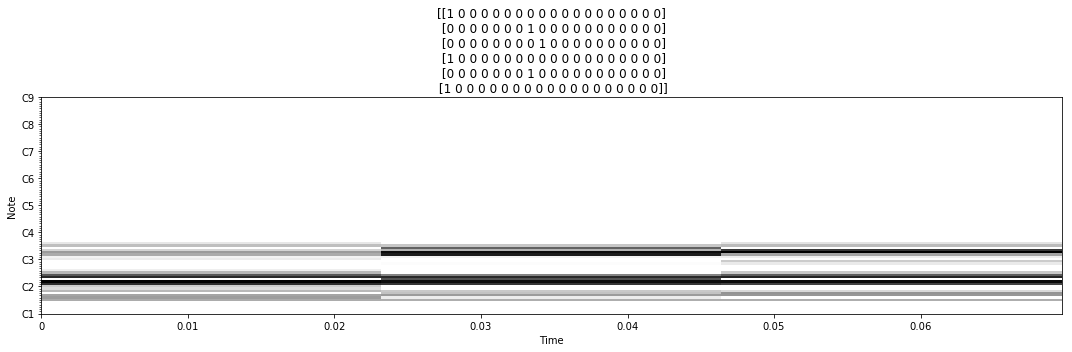

In [39]:
print(output["repr"][1])

plt.figure(figsize=(15,5))
librosa.display.specshow(output["repr"][1].astype('float64'), cmap='gray_r', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')
plt.title(output["labels"][1])
plt.tight_layout()
plt.show()

In [38]:
batch_size = 128
con_win_size = 9
label_dim = (6,21)

X_dim = (batch_size, 192, con_win_size, 1)
y_dim = (batch_size, label_dim[0], label_dim[1])

X = np.empty(X_dim)
y = np.empty(y_dim)

{'labels': array([[[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       ...,

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1,

In [61]:
print(labels)

[array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     

In [62]:
training_data = []

training_data.append([cqt, True_tab])

training_data = np.array(training_data)
print(len(training_data))

1


In [63]:
print(training_data.shape)

(1, 2)


In [64]:
print(training_data)

[[array([[-47.91390683, -47.91390683, -47.91390683],
       [-47.91390683, -47.91390683, -47.91390683],
       [-47.91390683, -47.91390683, -47.91390683],
       ...,
       [-47.91390683, -47.91390683, -47.91390683],
       [-47.91390683, -47.91390683, -47.91390683],
       [-47.91390683, -47.91390683, -47.91390683]])
  array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]]


In [81]:
X = training_data[:, 0:1]
y = training_data[:, 1]

In [87]:
print(X.shape)
print(y.shape)

(8, 1)
(8,)


## Model Architecture and Training

In [ ]:
# Optimizer
epochs = 30
learning_rate = 0.01 
momentum = 0.8
decay = learning_rate/epochs
sgd = SGD(lr = learning_rate, momentum = momentum, decay = decay, nesterov = False)

# Training (Functional Method)
model_in = Input(shape = input_shape)
conv1 = Conv2D(32, kernel_size = (3, 3), activation = 'relu')(model_in)
conv2 = Conv2D(64, kernel_size = (3, 3), activation = 'relu')(conv1)
conv3 = Conv2D(64, kernel_size = (3, 3), activation = 'relu')(conv2)
pool1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3)
flat = Flatten()(pool1)

# Create fully connected model heads
y1 = Dense(152, activation = 'relu')(flat)
y1 = Dropout(0.5)(y1)
y1 = Dense(76)(y1)
y1 = Dropout(0.2)(y1)

y2 = Dense(152, activation = 'relu')(flat)
y2 = Dropout(0.5)(y2)
y2 = Dense(76)(y2)
y2 = Dropout(0.2)(y2)

y3 = Dense(152, activation = 'relu')(flat)
y3 = Dropout(0.5)(y3)
y3 = Dense(76)(y3)
y3 = Dropout(0.2)(y3)

y4 = Dense(152, activation = 'relu')(flat)
y4 = Dropout(0.5)(y4)
y4 = Dense(76)(y4)
y4 = Dropout(0.2)(y4)

y5 = Dense(152, activation = 'relu')(flat)
y5 = Dropout(0.5)(y5)
y5 = Dense(76)(y5)
y5 = Dropout(0.2)(y5)

y6 = Dense(152, activation = 'relu')(flat)
y6 = Dropout(0.5)(y6)
y6 = Dense(76)(y6)
y6 = Dropout(0.2)(y6)

# Connect heads to final output layer
out1 = Dense(19, activation = 'softmax', name = 'estring')(y1)
out2 = Dense(19, activation = 'softmax', name = 'Bstring')(y2)
out3 = Dense(19, activation = 'softmax', name = 'Gstring')(y3)
out4 = Dense(19, activation = 'softmax', name = 'Dstring')(y4)
out5 = Dense(19, activation = 'softmax', name = 'Astring')(y5)
out6 = Dense(19, activation = 'softmax', name = 'Estring')(y6)

# Create model
model = Model(inputs = model_in, outputs = [out1, out2, out3, out4, out5, out6])
model.compile(optimizer = sgd, loss = ['categorical_crossentropy', 'categorical_crossentropy', 
                                       'categorical_crossentropy', 'categorical_crossentropy', 
                                       'categorical_crossentropy', 'categorical_crossentropy'], 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, [e_train, B_train, G_train, D_train, A_train, E_train], 
                    batch_size = batch_size, epochs = epochs, verbose = 1, 
                    validation_data = (x_test, [e_test, B_test, G_test, D_test, A_test, E_test]))
score = model.evaluate(x_test, [e_test, B_test, G_test, D_test, A_test, E_test], verbose = 1)

In [ ]:
print(f"Test accuracy estring: {score}")
print(f"Test accuracy Bstring: {score}")
print(f"Test accuracy Gstring: {score}")
print(f"Test accuracy Dstring: {score}")
print(f"Test accuracy Astring: {score}")
print(f"Test accuracy Estring: {score}")